In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import cuml
import cudf  # looks and feels like Pandas, but runs on the GPU
from cuml.preprocessing.TargetEncoder import TargetEncoder
from cuml.preprocessing.model_selection import train_test_split
from cuml.metrics import accuracy_score,roc_auc_score

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

In [2]:
train_dir = '/kaggle/input/tabular-playground-series-mar-2021/train.csv'
test_dir = '/kaggle/input/tabular-playground-series-mar-2021/test.csv'

In [3]:
%%time
df_dd = dd.read_csv(train_dir).compute()

CPU times: user 1.07 s, sys: 254 ms, total: 1.32 s
Wall time: 3 s


In [4]:
%%time
df_cudf = cudf.read_csv(train_dir)

CPU times: user 1.08 s, sys: 643 ms, total: 1.72 s
Wall time: 3.53 s


In [5]:
train_df = pd.read_csv(train_dir)
train_df.drop(columns = 'id', axis = 1, inplace = True)
test_df = pd.read_csv(test_dir)
ids = test_df['id']
test_df.drop(columns = 'id', axis = 1, inplace = True)

In [6]:
train_df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,A,I,A,B,B,BI,A,S,Q,A,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [7]:
train_df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


# EDA

In [8]:
dct = {}
for trgt in train_df['target']:
    if(trgt not in dct):
        dct[trgt] = 1
    else:
        dct[trgt] += 1

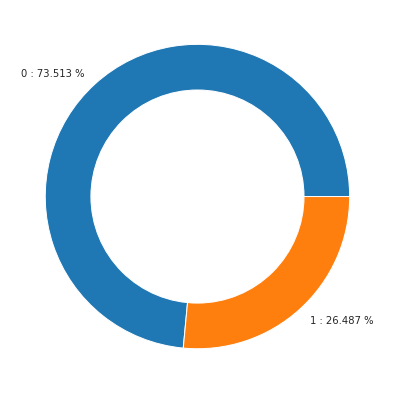

In [9]:
plt.figure(figsize = (7,7))
plt.pie(dct.values(), labels = [f'0 : {dct[0]/3000} %', f'1 : {dct[1]/3000} %'])

my_circle = plt.Circle( (0,0), 0.7, color='white')
fig = plt.gcf()
fig.gca().add_artist(my_circle)
plt.show()

In [10]:
categorical_columns = []
for i in range(19):
    categorical_columns.append('cat'+str(i))
numerical_columns = []
for i in range(11):
    numerical_columns.append('cont'+str(i))


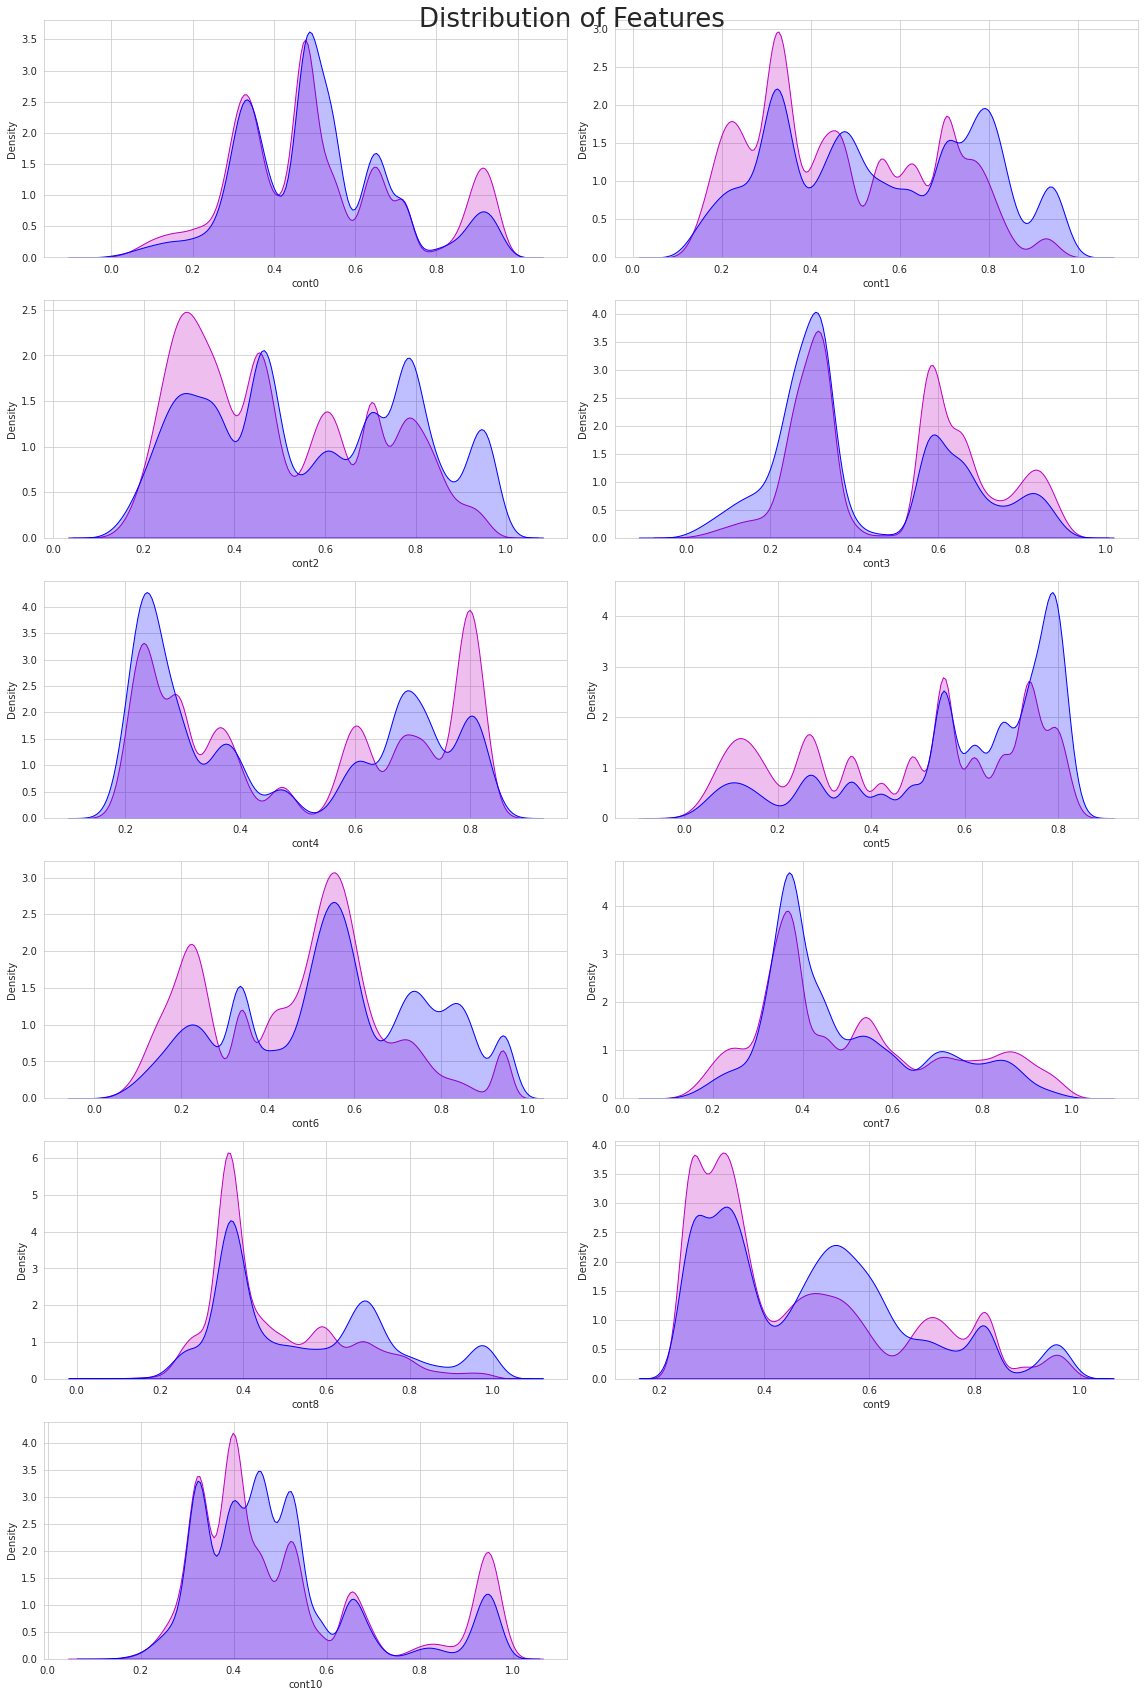

In [11]:
num_rows, num_cols = 6,2
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 24))
f.suptitle('Distribution of Features', fontsize=26)

for index, column in enumerate(train_df[numerical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    sns.kdeplot(train_df.loc[train_df['target'] == 0, column], color = "m", shade = True, ax = axes[i,j])
    sns.kdeplot(train_df.loc[train_df['target'] == 1, column], color = "b", shade = True, ax = axes[i,j])

f.delaxes(axes[5, 1])
plt.tight_layout()
plt.show()

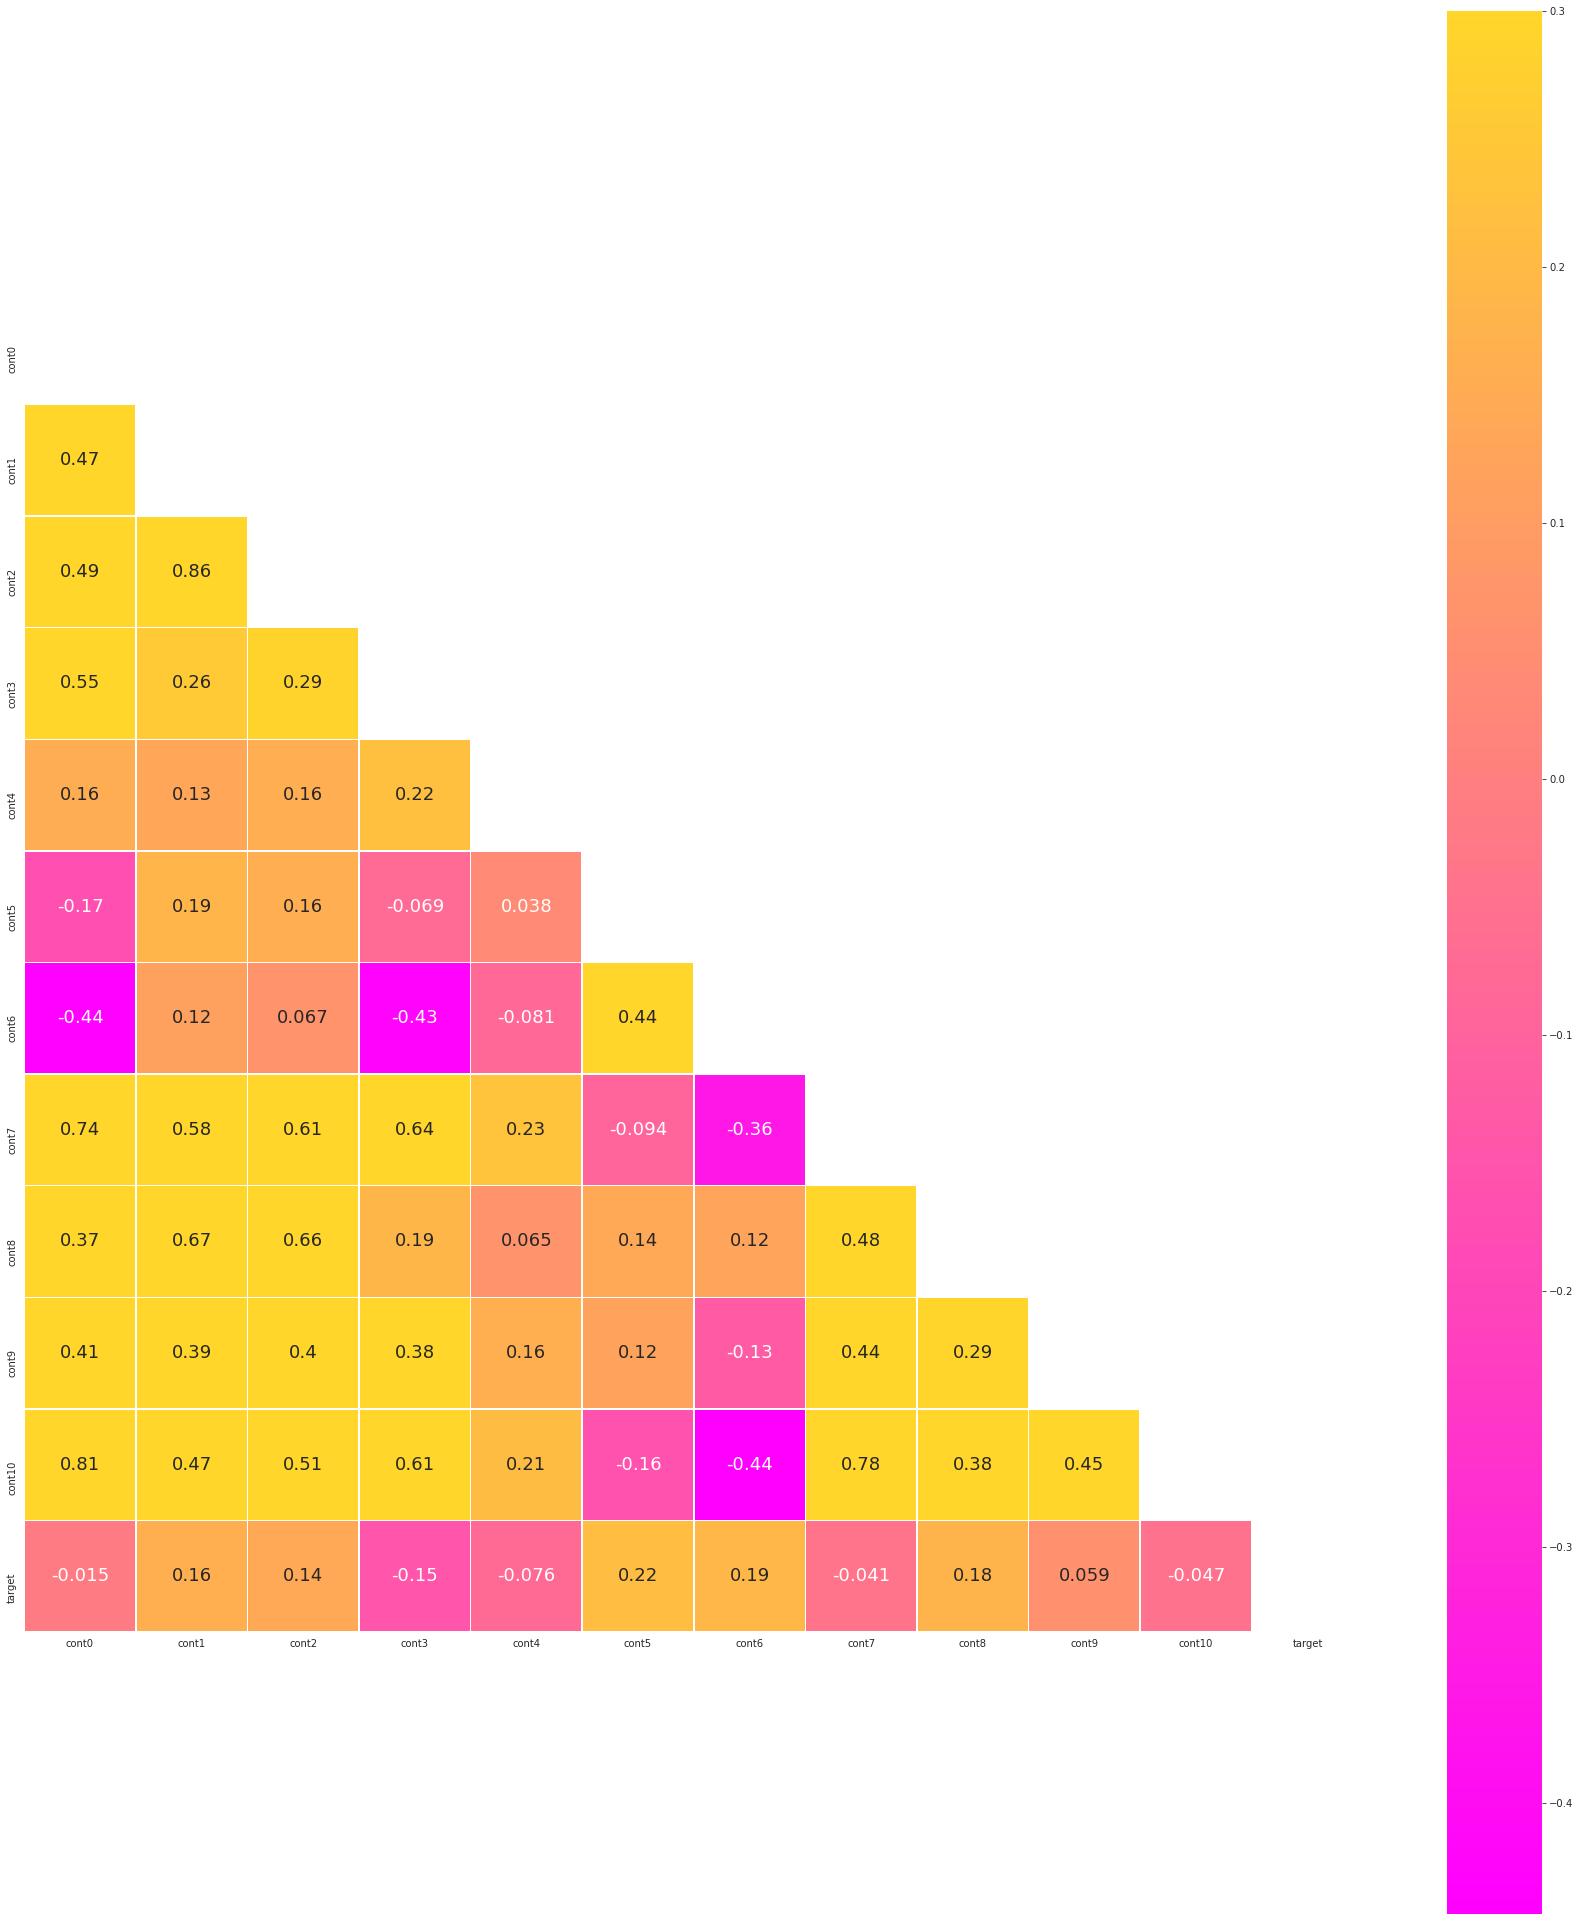

In [12]:
plt.figure(figsize = (30,35))
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = 'spring', vmax = .3, center = 0,
            square = True, linewidths = .5, annot=True, annot_kws={"fontsize":18})
plt.show()

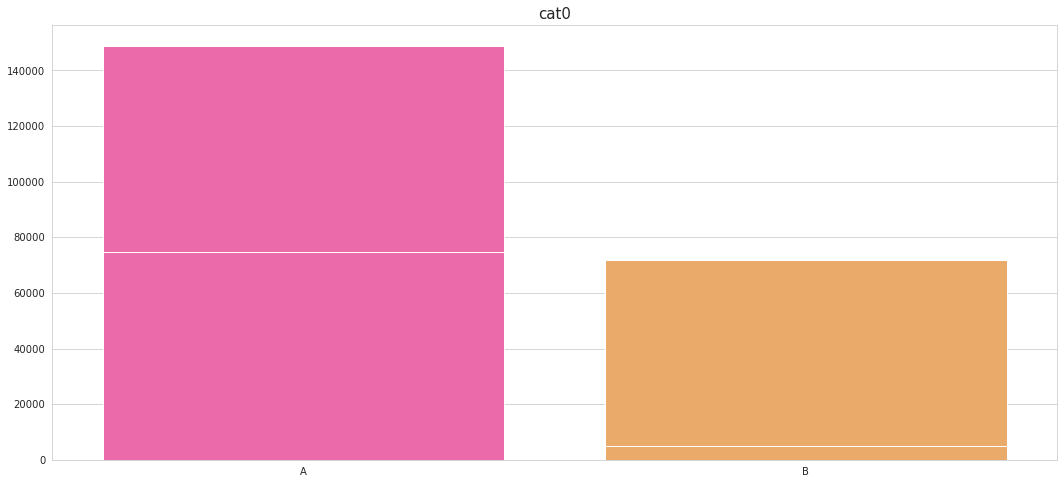

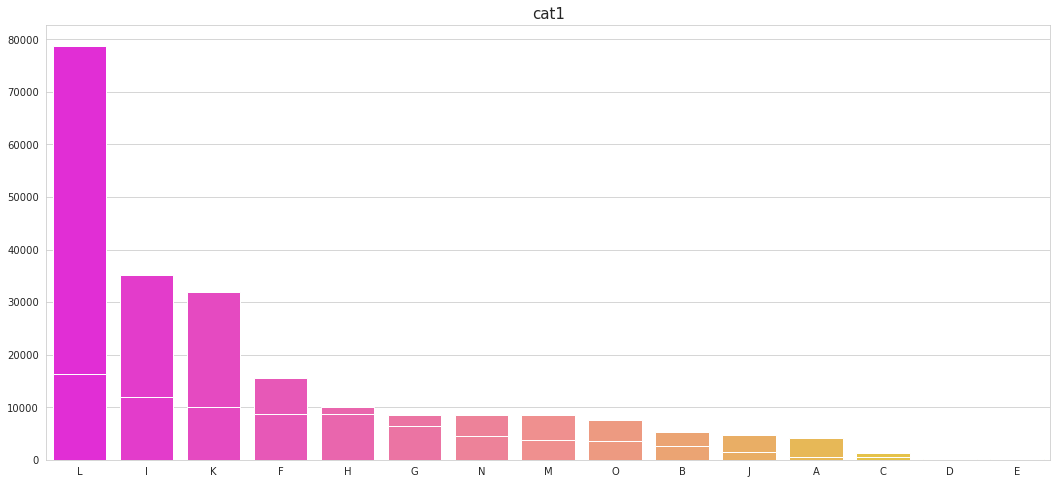

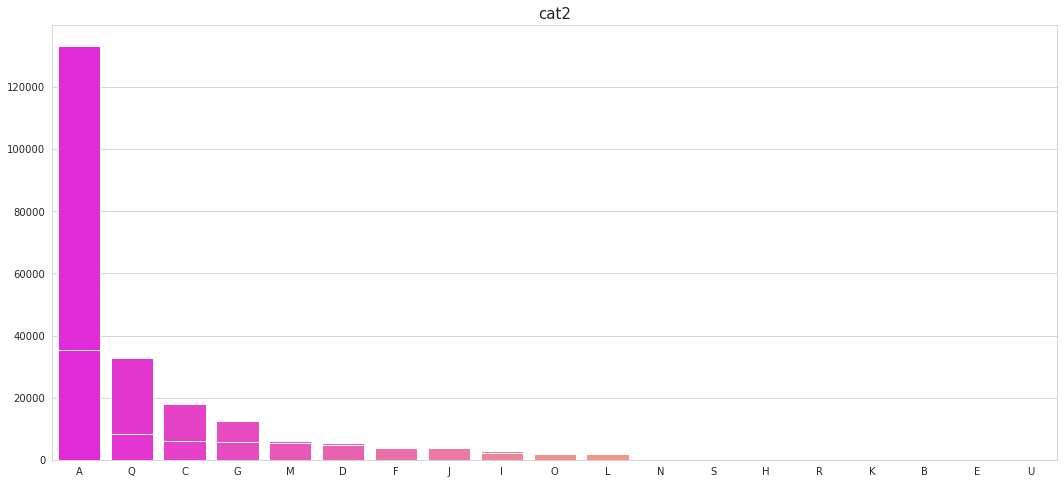

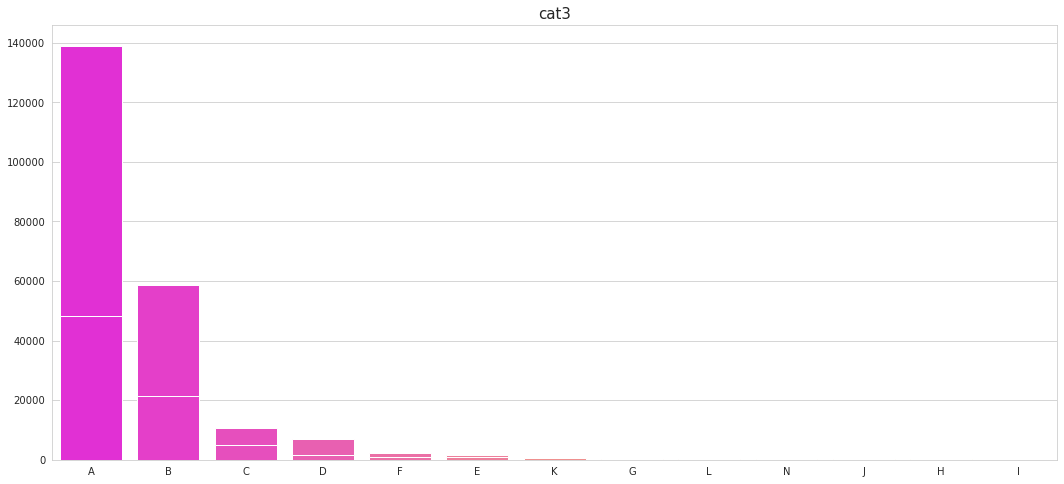

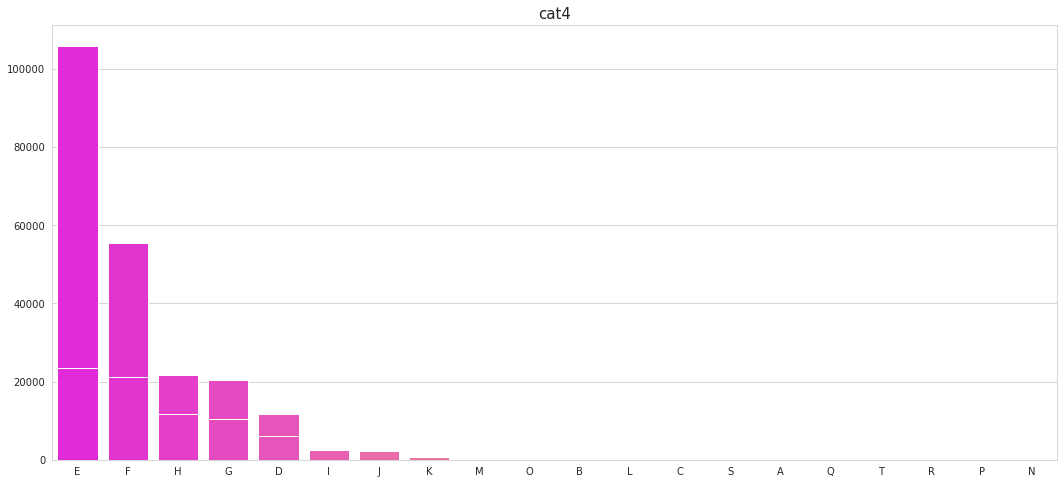

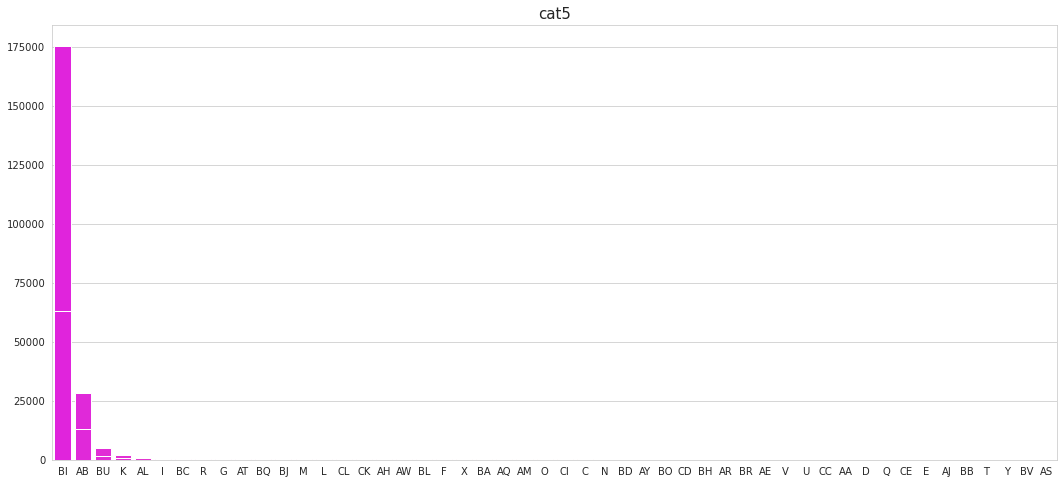

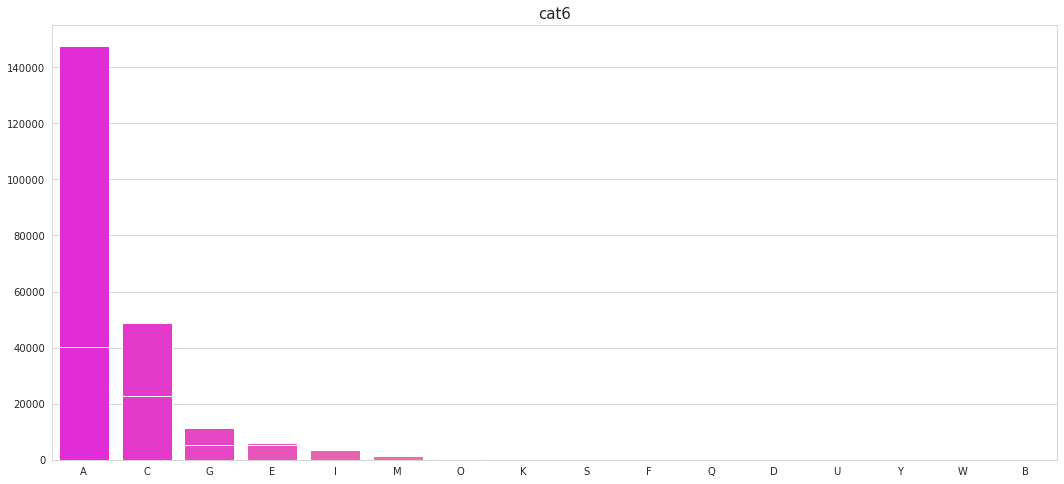

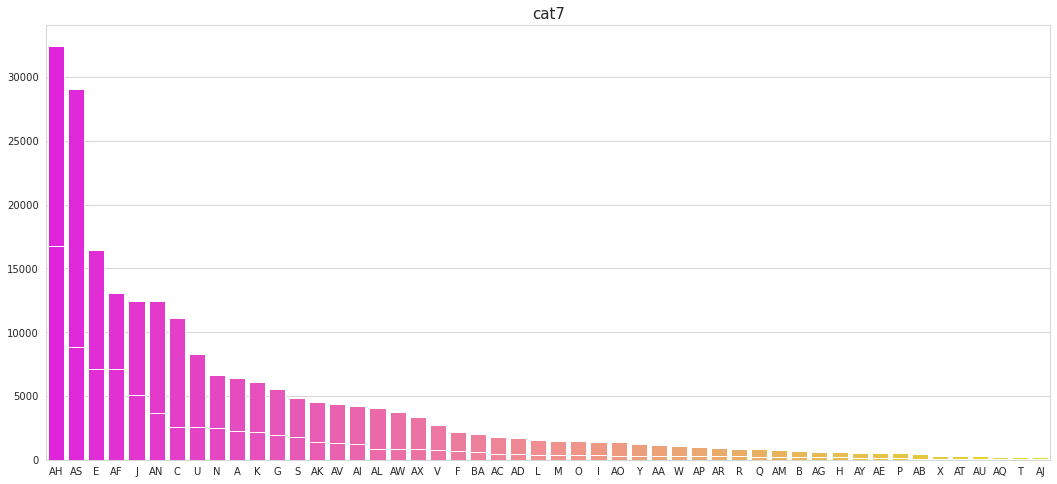

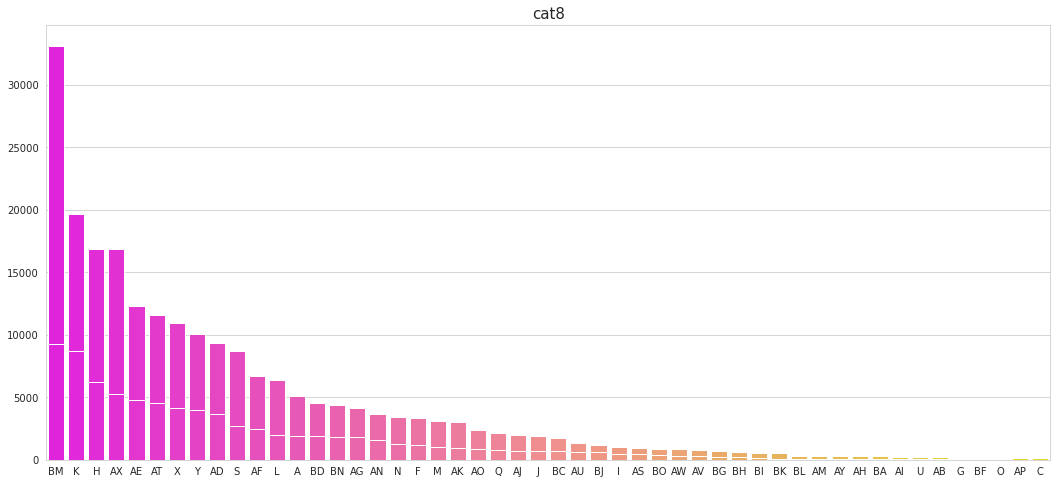

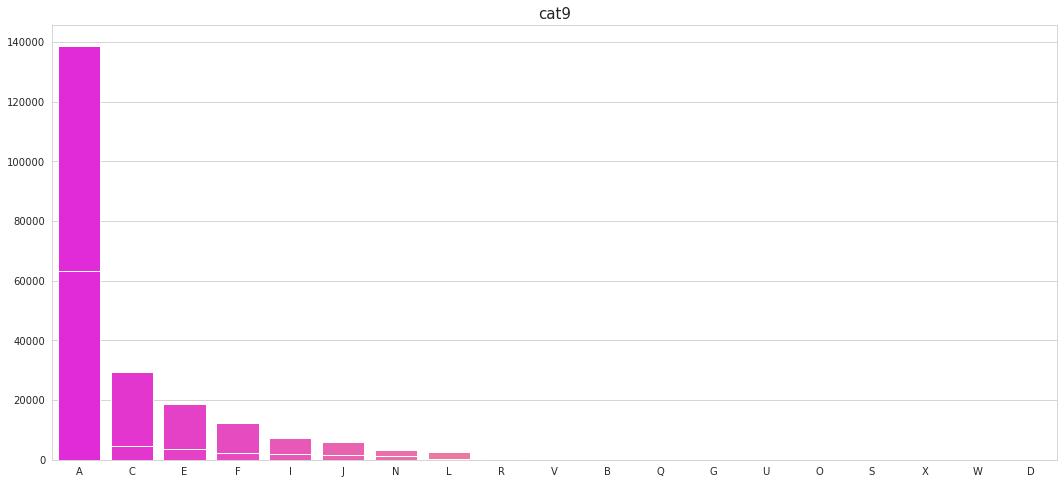

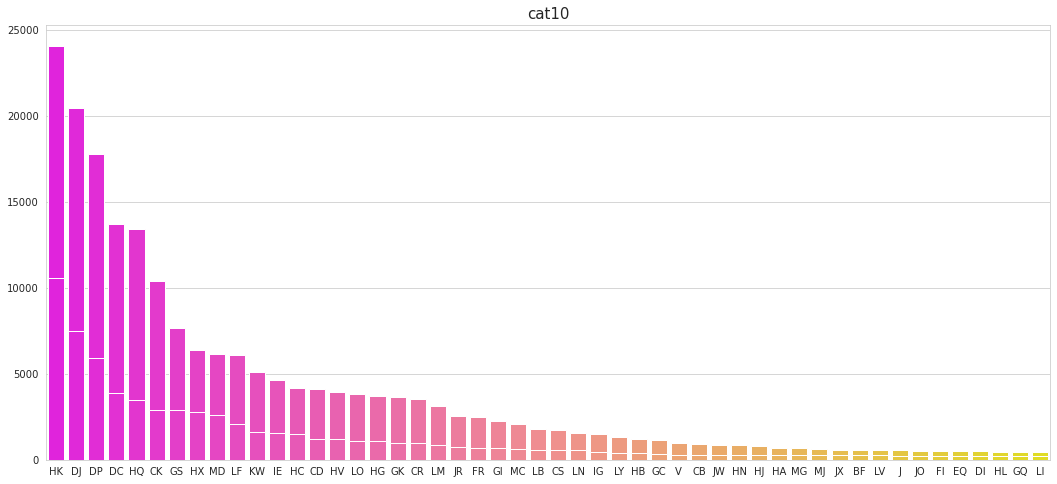

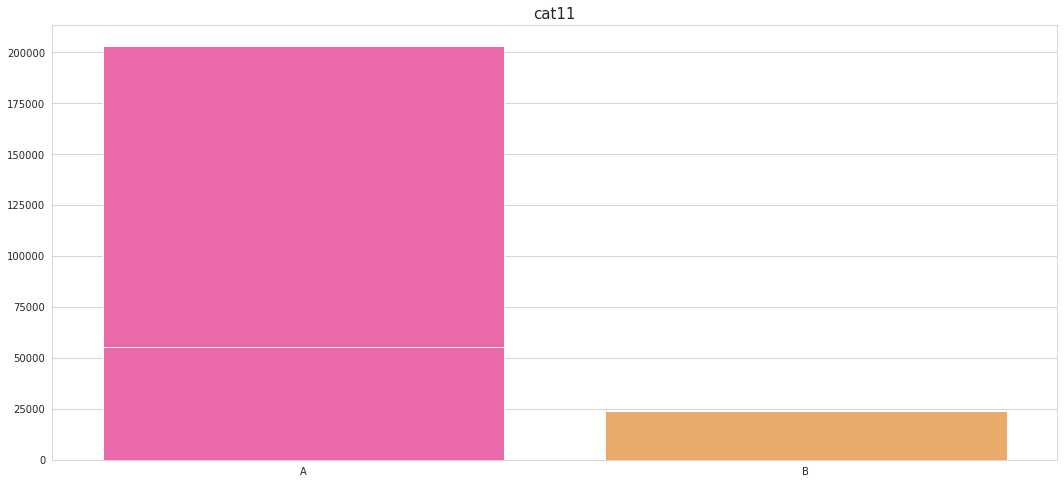

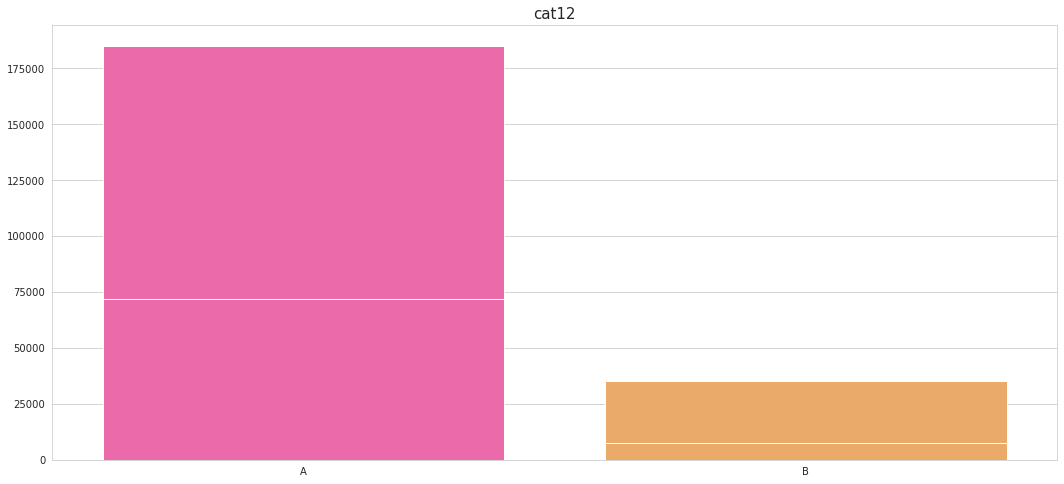

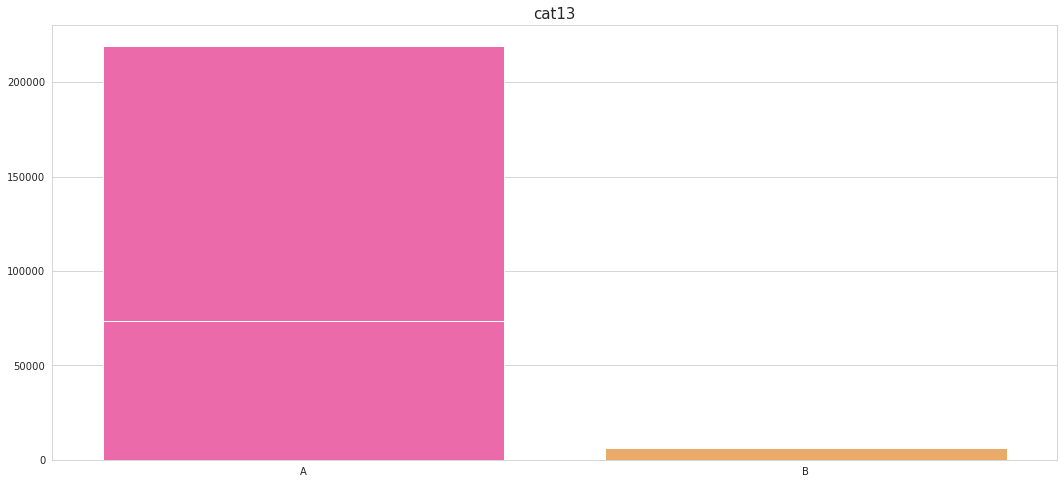

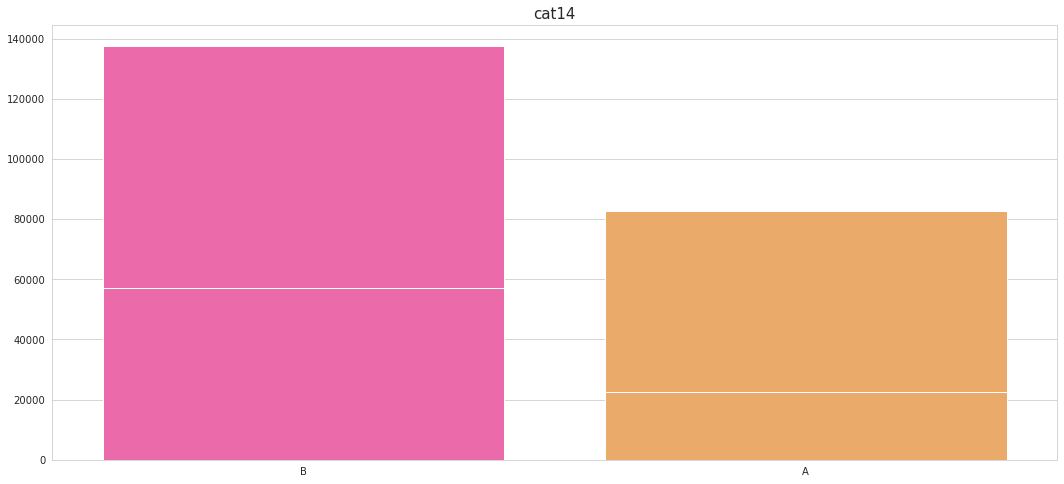

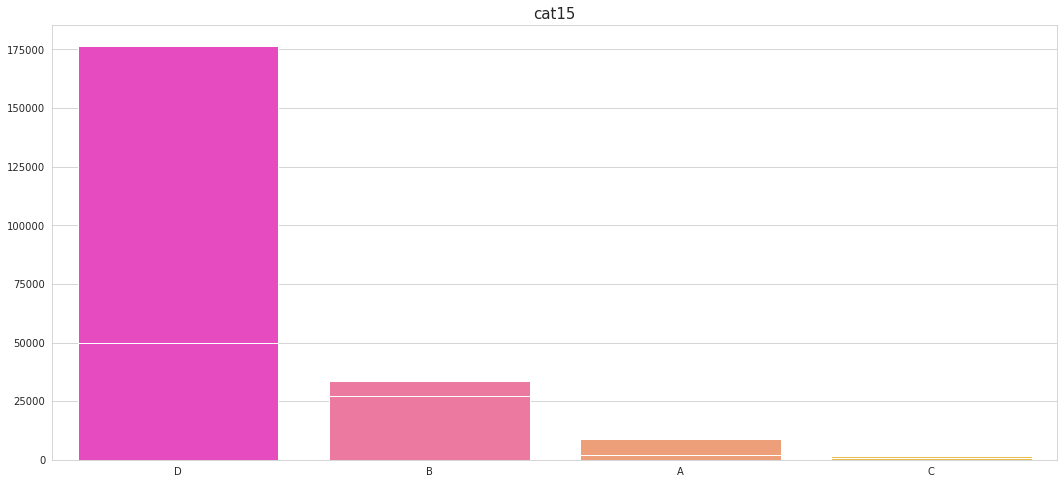

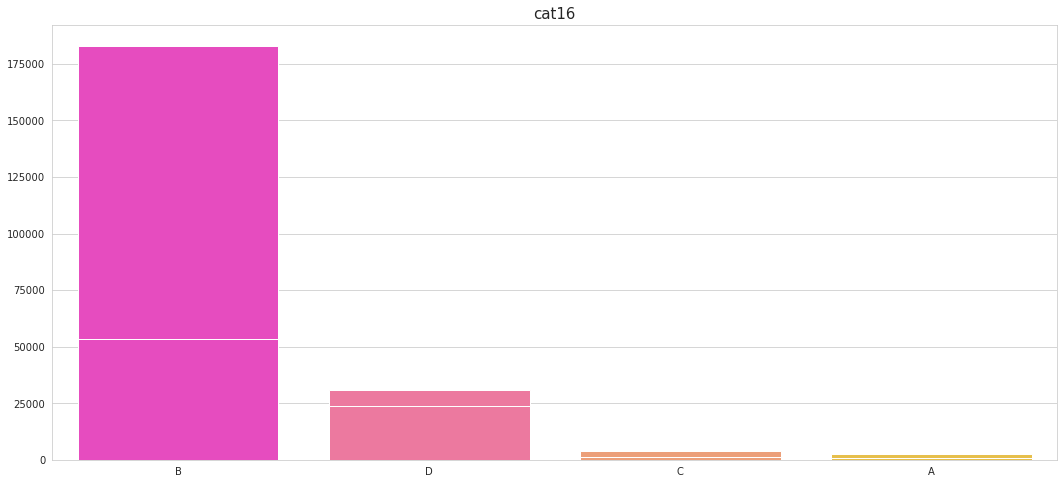

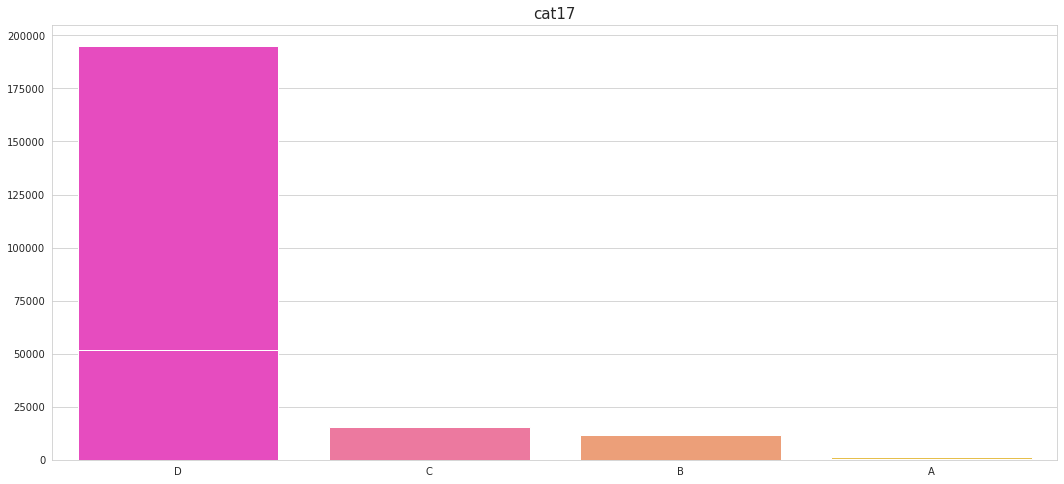

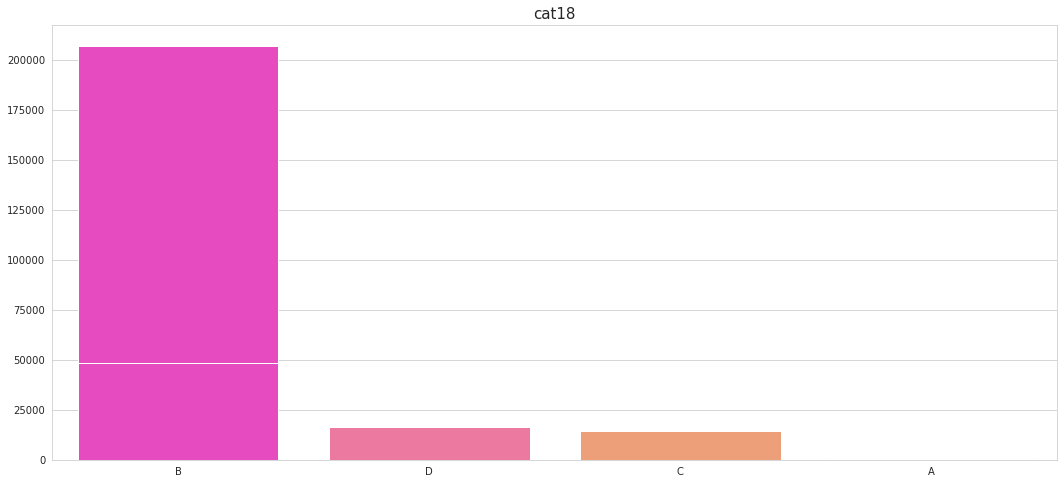

In [13]:
 for index, column in enumerate(train_df[categorical_columns].columns):
    index_0 = train_df.loc[train_df['target'] == 0, column].value_counts().reset_index()["index"].values
    values_0 = train_df.loc[train_df['target'] == 0, column].value_counts().reset_index()['cat'+str(index)].values
    index_1 = train_df.loc[train_df['target'] == 1, column].value_counts().reset_index()["index"].values
    values_1 = train_df.loc[train_df['target'] == 1, column].value_counts().reset_index()['cat'+str(index)].values
    if len(values_0)>10:
        index_0 = index_0[:50]
        values_0 = values_0[:50]
    if len(values_1)>10:
        index_1 = index_1[:50]
        values_1 = values_1[:50]
        
    plt.figure(figsize = (18, 8))
    
    sns.barplot(x = index_0, y = values_0, palette = 'spring')
    sns.barplot(x = index_1, y = values_1, palette = 'spring')
    
    plt.title(categorical_columns[index], fontsize=15)
plt.show()    

# Feature Engineering

In [14]:
from copy import deepcopy

df_0 = train_df.loc[train_df['target'] == 0]
df_1 = train_df.loc[train_df['target'] == 1]

for index, column in enumerate(train_df[categorical_columns].columns):
    data = df_0.groupby(column)[column].count().sort_values(ascending=False)
    if len(data) < 10:
        continue
    # data = data if len(data) < 25 else data[:25]
    
    target_0_values = set(deepcopy(data.index))
    
    data = df_1.groupby(column)[column].count().sort_values(ascending=False)
    # data = data if len(data) < 25 else data[:25]
    
    target_1_values = set(deepcopy(data.index))
    
    print('-------------------   {}   ---------------------'.format(column))
    print('Unique values for class 0: {}'.format(target_0_values - target_1_values))
    print('Unique values for class 1: {}'.format(target_1_values - target_0_values))


-------------------   cat1   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat2   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat3   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat4   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat5   ---------------------
Unique values for class 0: {'B', 'BM', 'AK', 'BX', 'ZZ', 'CB', 'AG', 'BP'}
Unique values for class 1: set()
-------------------   cat6   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat7   ---------------------
Unique values for class 0: set()
Unique values for class 1: set()
-------------------   cat8   ---------------------
Unique values for class 0: {'AC', 'P'}
Unique values for class 1: set()
----------------

In [15]:
# Fix cat5 variable
train_df['cat5'] = train_df['cat5'].apply(lambda x: x if x not in 
                                          ['AG', 'CB', 'BP', 'ZZ', 'BM', 'BX', 'AK', 'B'] 
                                          else 'B')
test_df['cat5'] = test_df['cat5'].apply(lambda x: x if x not in 
                                        ['AG', 'CB', 'BP', 'ZZ', 'BM', 'BX', 'AK', 'B'] 
                                        else 'B')

# Fix cat8 variable
train_df['cat8'] = train_df['cat8'].apply(lambda x: x if x not in ['AC', 'P'] else 'P')
test_df['cat8'] = test_df['cat8'].apply(lambda x: x if x not in ['AC', 'P'] else 'P')

# Fix cat10 variable
train_df['cat10'] = train_df['cat10'].apply(lambda x: x if x not in 
                                            ['HF', 'KK', 'GD', 'JE', 'KD', 'MA', 'BA', 'DT', 
                                             'LK', 'GR', 'KU', 'MW', 'LR', 'ME', 'CN', 'JF', 
                                             'DA', 'JC', 'IU', 'GV', 'ED', 'EB', 'IL', 'EF', 
                                             'BD', 'GG', 'CM', 'CH', 'EG', 'FA', 'KN', 'IM', 
                                             'DU', 'IN', 'HI', 'DX', 'IP', 'DM', 'CF', 'MO', 
                                             'DL', 'KI', 'FW', 'GH', 'MP', 'MR', 'BO', 'IY', 
                                             'CQ', 'GF', 'AF', 'CX', 'MQ', 'GJ', 'FF', 'LT', 
                                             'AJ', 'IQ', 'HY', 'LH', 'DN', 'MK', 'GY', 'BS', 
                                             'DK', 'AW', 'JU', 'BX', 'CT', 'EH', 'ML', 'EN', 
                                             'MU', 'MI'] else 'MI')
test_df['cat10'] = test_df['cat10'].apply(lambda x: x if x not in 
                                        ['HF', 'KK', 'GD', 'JE', 'KD', 'MA', 'BA', 'DT', 
                                         'LK', 'GR', 'KU', 'MW', 'LR', 'ME', 'CN', 'JF', 
                                         'DA', 'JC', 'IU', 'GV', 'ED', 'EB', 'IL', 'EF', 
                                         'BD', 'GG', 'CM', 'CH', 'EG', 'FA', 'KN', 'IM', 
                                         'DU', 'IN', 'HI', 'DX', 'IP', 'DM', 'CF', 'MO', 
                                         'DL', 'KI', 'FW', 'GH', 'MP', 'MR', 'BO', 'IY', 
                                         'CQ', 'GF', 'AF', 'CX', 'MQ', 'GJ', 'FF', 'LT', 
                                         'AJ', 'IQ', 'HY', 'LH', 'DN', 'MK', 'GY', 'BS', 
                                         'DK', 'AW', 'JU', 'BX', 'CT', 'EH', 'ML', 'EN', 
                                         'MU', 'MI'] else 'MI')

I used **Target encoding** which works by averaging the target value by category.

* Target encoding is a fast way to get the most out of your categorical variables with little effort. The idea is quite simple. Say you have a categorical variable X and a target y – y can be binary or continuous, it doesn’t matter. For each distinct element in X you’re going to compute the average of the corresponding values in y. Then you’re going to replace each Xi with the according mean.

Here **stratify** parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter **stratify**.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's

In [16]:
encoder = TargetEncoder()

X = cudf.DataFrame(train_df.drop(["target"],axis=1))
y = cudf.Series(train_df["target"])
test_df = cudf.DataFrame(test_df)

for col in train_df.columns:
    if train_df[col].dtype=='object':
        print(col)
        X[col] = encoder.fit_transform(X[col],y)
        test_df[col] = encoder.transform(test_df[col])

cat0
cat1
cat2
cat3
cat4
cat5
cat6
cat7
cat8
cat9
cat10
cat11
cat12
cat13
cat14
cat15
cat16
cat17
cat18


# Modelling

In [17]:
from lightgbm import LGBMClassifier
import xgboost
import lightgbm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# LGBM

In [18]:
k_fold = 8
skf = StratifiedKFold(n_splits=k_fold)

In [19]:
params = {'n_estimators': 10000,
 'learning_rate': 0.05,
 'metric': 'auc',
 'num_leaves': 708,
 'max_depth': 31,
 'reg_alpha': 11.308,
 'reg_lambda': 15.091,
 'colsample_bytree': 0.233,
 'force_col_wise': True,
 'cat_smooth': 39.657}

for i, (train_index, test_index) in enumerate(skf.split(X, y.to_array())):
    print('[Fold %d/%d]' % (i + 1, k_fold))
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBM format
    d_train = lightgbm.Dataset(X_train.to_pandas(), label = y_train.to_pandas())
    d_valid = lightgbm.Dataset(X_valid.to_pandas(), label = y_valid.to_pandas())
    d_test = lightgbm.Dataset(test_df)

    mdl = lightgbm.train(params, d_train, 1000, valid_sets = [d_train, d_valid], 
                         early_stopping_rounds=300, verbose_eval=500)

    # Predicting...
    p_test = mdl.predict(d_test)
    sub['target_'+str(k)] += p_test/k_fold

[Fold 1/8]
[LightGBM] [Info] Total Bins 4268
[LightGBM] [Info] Number of data points in the train set: 262500, number of used features: 30
[LightGBM] [Info] Start training from score 0.264872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


KeyboardInterrupt: 

In [20]:
lgbm = LGBMClassifier()

lgbm.fit(X_train.as_matrix(), 
         y_train.to_array(), 
         eval_set = (X_valid.as_matrix(), y_valid.to_array()), 
         verbose = True)
predictions = lgbm.predict_proba(X_valid.as_matrix())[:,1]

auc = roc_auc_score(y_valid, predictions)

print(f'LGBM Score: {auc}')

[1]	valid_0's binary_logloss: 0.542433
[2]	valid_0's binary_logloss: 0.515151
[3]	valid_0's binary_logloss: 0.493497
[4]	valid_0's binary_logloss: 0.475597
[5]	valid_0's binary_logloss: 0.460814
[6]	valid_0's binary_logloss: 0.448197
[7]	valid_0's binary_logloss: 0.437522
[8]	valid_0's binary_logloss: 0.428209
[9]	valid_0's binary_logloss: 0.420222
[10]	valid_0's binary_logloss: 0.413129
[11]	valid_0's binary_logloss: 0.407131
[12]	valid_0's binary_logloss: 0.401896
[13]	valid_0's binary_logloss: 0.397064
[14]	valid_0's binary_logloss: 0.392906
[15]	valid_0's binary_logloss: 0.389305
[16]	valid_0's binary_logloss: 0.386027
[17]	valid_0's binary_logloss: 0.382993
[18]	valid_0's binary_logloss: 0.380313
[19]	valid_0's binary_logloss: 0.377934
[20]	valid_0's binary_logloss: 0.375736
[21]	valid_0's binary_logloss: 0.373776
[22]	valid_0's binary_logloss: 0.372068
[23]	valid_0's binary_logloss: 0.370492
[24]	valid_0's binary_logloss: 0.368989
[25]	valid_0's binary_logloss: 0.36777
[26]	valid

In [21]:
preds_lgbm = lgbm.predict_proba(test_df.as_matrix())[:,1]

In [22]:
preds_lgbm

array([0.13297523, 0.38730847, 0.02093512, ..., 0.67906852, 0.11636863,
       0.40165501])

In [ ]:
df_sub = {'id': ids, 'target': preds_lgbm}
df_predictions = cudf.DataFrame(df_sub).set_index(['id'])

df_predictions.to_csv('/kaggle/working/predictions_lgbm.csv')

# XGBoost

In [23]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [24]:
k_fold = 8
skf = StratifiedKFold(n_splits=k_fold)

In [25]:
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = np.zeros_like(ids)

In [27]:
params =   {'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'eval_metric': 'auc',
        'random_state': 1,
        'max_depth': 12,
        'learning_rate': 0.03,
        'min_child_weight': 20,
        'gamma': 0.1,
        'alpha': 0.2,
        'lambda': 9,
        'colsample_bytree': 0.2,
        'subsample': 0.8}
for i, (train_index, test_index) in enumerate(skf.split(X, y.to_array())):
    print('[Fold %d/%d]' % (i + 1, k_fold))
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgboost.DMatrix(X_train, y_train)
    d_valid = xgboost.DMatrix(X_valid, y_valid)
    d_test = xgboost.DMatrix(test_df)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgboost.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=500)

    # Predicting...
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/k_fold

[Fold 1/8]
[0]	train-auc:0.77144	train-gini:0.54283	valid-auc:0.77201	valid-gini:0.54385
[500]	train-auc:0.92832	train-gini:0.85663	valid-auc:0.89772	valid-gini:0.79545
[767]	train-auc:0.93831	train-gini:0.87662	valid-auc:0.89799	valid-gini:0.79599
[Fold 2/8]
[0]	train-auc:0.77153	train-gini:0.54298	valid-auc:0.76516	valid-gini:0.53002
[500]	train-auc:0.92914	train-gini:0.85829	valid-auc:0.89440	valid-gini:0.78880
[769]	train-auc:0.93885	train-gini:0.87770	valid-auc:0.89464	valid-gini:0.78928
[Fold 3/8]
[0]	train-auc:0.77152	train-gini:0.54295	valid-auc:0.76948	valid-gini:0.53883
[500]	train-auc:0.92864	train-gini:0.85728	valid-auc:0.89660	valid-gini:0.79320
[833]	train-auc:0.94103	train-gini:0.88206	valid-auc:0.89688	valid-gini:0.79376
[Fold 4/8]
[0]	train-auc:0.77243	train-gini:0.54475	valid-auc:0.76588	valid-gini:0.53215
[500]	train-auc:0.92825	train-gini:0.85650	valid-auc:0.89577	valid-gini:0.79154
[884]	train-auc:0.94183	train-gini:0.88367	valid-auc:0.89611	valid-gini:0.79221
[Fol

In [28]:
target_ = sub['target']
df_sub = {'id': ids, 'target': target_}
df_predictions = cudf.DataFrame(df_sub).set_index(['id'])

df_predictions.to_csv('/kaggle/working/predictions_xgb_.csv')